In [2]:
# NOTE: Loading data from Google Drive is VERY SLOW. Therefore, we download the data to a local storage
# specified by VOC_PATH.
# This means the data would have be re-downloaded everytime.
# Change this path if you are running this script locally
VOC_PATH="./VOC_DATA"



In [3]:
# %%bash
# VOC_PATH="./VOC_DATA"
# chmod u+x ./download_data.sh
# sed -i 's/\r//g' ./download_data.sh
# cat ./download_data.sh
# bash ./download_data.sh $VOC_PATH

In [4]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader

from src.resnet_yolo import resnet50
import yolo_loss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt # type: ignore
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## **Start from here if you modified yolo_loss.py and wish to retrain**

In [7]:
# We recommend tuning only the batch size; the remaining hyperparameters should work well
# with the default values. However, you are free to experiment with them.

learning_rate = 0.001
num_epochs = 50
batch_size = 12

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [8]:
file_root_train = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007/JPEGImages/')
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=12)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [9]:
file_root_test = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007test/JPEGImages/')
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=12)
print('Loaded %d test images' % len(test_dataset))


Initializing dataset
Loaded 4950 test images


In [10]:
data = train_dataset[0]

## Initializing the network

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [11]:
# load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from ./checkpoints/detector_epoch_5.pth


C:\Users\Carlos\AppData\Local\Temp\ipykernel_68196\1758350888.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(load_network_path))


## Set up training tools

In [41]:
from importlib import reload
reload(yolo_loss) # update the import if the implementation has changed

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-4)


## Train detector

In [42]:
import time
best_test_loss = np.inf
learning_rate = learning_rate
start_time = time.time()
os.makedirs('./checkpoints', exist_ok=True)
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    print("Runtime: %.2f, Epoch took: %.2f min" % (time.time() / 60, (time.time() - start_time) / 60))
    torch.save(net.state_dict(),'checkpoints/detector.pth')




Starting epoch 1 / 50
Learning Rate for this epoch: 1e-05
Epoch [1/50], Iter [50/418], Loss: total=2.008, reg=0.967, containing_obj=0.626, no_obj=0.195, cls=0.220
Epoch [1/50], Iter [100/418], Loss: total=1.988, reg=0.974, containing_obj=0.612, no_obj=0.192, cls=0.210
Epoch [1/50], Iter [150/418], Loss: total=1.965, reg=0.952, containing_obj=0.608, no_obj=0.195, cls=0.210
Epoch [1/50], Iter [200/418], Loss: total=1.936, reg=0.936, containing_obj=0.604, no_obj=0.193, cls=0.202
Epoch [1/50], Iter [250/418], Loss: total=1.955, reg=0.952, containing_obj=0.606, no_obj=0.192, cls=0.205
Epoch [1/50], Iter [300/418], Loss: total=1.955, reg=0.951, containing_obj=0.606, no_obj=0.192, cls=0.205
Epoch [1/50], Iter [350/418], Loss: total=1.984, reg=0.967, containing_obj=0.614, no_obj=0.192, cls=0.211
Epoch [1/50], Iter [400/418], Loss: total=1.968, reg=0.961, containing_obj=0.609, no_obj=0.193, cls=0.205
Updating best test loss: 2.55737
Runtime: 29086493.50, Epoch took: 6.07 min


Starting epoch 

100%|██████████| 4950/4950 [01:59<00:00, 41.29it/s]


---class aeroplane ap 0.5043015282278073---
---class bicycle ap 0.6773606137621415---
---class bird ap 0.44120655042767154---
---class boat ap 0.3099732563984594---
---class bottle ap 0.14375537777761727---
---class bus ap 0.6226174894737079---
---class car ap 0.6408518217644554---
---class cat ap 0.7202477122819776---
---class chair ap 0.2830660821498139---
---class cow ap 0.5343924785756844---
---class diningtable ap 0.39049601310690446---
---class dog ap 0.7003474780529089---
---class horse ap 0.709946997774902---
---class motorbike ap 0.5869946522882454---
---class person ap 0.500431298258442---
---class pottedplant ap 0.17273352365610106---
---class sheep ap 0.451075143224862---
---class sofa ap 0.4511487227192126---
---class train ap 0.636534752306345---
---class tvmonitor ap 0.47180636270716836---
---map 0.4974643927467214---
4 [np.float64(0.5043015282278073), np.float64(0.6773606137621415), np.float64(0.44120655042767154), np.float64(0.3099732563984594), np.float64(0.1437553777

100%|██████████| 4950/4950 [01:53<00:00, 43.75it/s]


---class aeroplane ap 0.5110567491542779---
---class bicycle ap 0.674480392409495---
---class bird ap 0.4780949143035722---
---class boat ap 0.32924003045234157---
---class bottle ap 0.1794282706619576---
---class bus ap 0.6534453182960254---
---class car ap 0.6756108689264962---
---class cat ap 0.7452438391597491---
---class chair ap 0.31853263580898583---
---class cow ap 0.5412112448838335---
---class diningtable ap 0.4021632294061467---
---class dog ap 0.6661154121963877---
---class horse ap 0.6877876659752677---
---class motorbike ap 0.6025386560725838---
---class person ap 0.5372200630967134---
---class pottedplant ap 0.20253881333901438---
---class sheep ap 0.5220922571866156---
---class sofa ap 0.45537918241163866---
---class train ap 0.6397049940836173---
---class tvmonitor ap 0.510919574874078---
---map 0.5166402056349398---
9 [np.float64(0.5110567491542779), np.float64(0.674480392409495), np.float64(0.4780949143035722), np.float64(0.32924003045234157), np.float64(0.1794282706

100%|██████████| 4950/4950 [01:53<00:00, 43.48it/s]


---class aeroplane ap 0.49396557166333854---
---class bicycle ap 0.6458986166491953---
---class bird ap 0.45891772808236975---
---class boat ap 0.3187974195132091---
---class bottle ap 0.1749032673061928---
---class bus ap 0.663701759769374---
---class car ap 0.6623439930786745---
---class cat ap 0.7351179363401772---
---class chair ap 0.3203349685830117---
---class cow ap 0.5279671451987518---
---class diningtable ap 0.4103546027354925---
---class dog ap 0.6891053364522048---
---class horse ap 0.7045628782751363---
---class motorbike ap 0.5825256265927303---
---class person ap 0.5324891141920531---
---class pottedplant ap 0.19031504335642507---
---class sheep ap 0.5281758636956373---
---class sofa ap 0.4823955882524575---
---class train ap 0.6465161174112015---
---class tvmonitor ap 0.5254333676539986---
---map 0.5146910972400816---
14 [np.float64(0.49396557166333854), np.float64(0.6458986166491953), np.float64(0.45891772808236975), np.float64(0.3187974195132091), np.float64(0.1749032

100%|██████████| 4950/4950 [01:54<00:00, 43.25it/s]


---class aeroplane ap 0.5006551915521552---
---class bicycle ap 0.6521257371183233---
---class bird ap 0.5038827315301657---
---class boat ap 0.31808675488603955---
---class bottle ap 0.19228929347757973---
---class bus ap 0.6397279278990682---
---class car ap 0.6703458933671793---
---class cat ap 0.7204356908763405---
---class chair ap 0.31472819355040776---
---class cow ap 0.5327150778903096---
---class diningtable ap 0.4099861993724629---
---class dog ap 0.6795501071438432---
---class horse ap 0.6901173009282385---
---class motorbike ap 0.5725876614730714---
---class person ap 0.5278891205282898---
---class pottedplant ap 0.20185695873046092---
---class sheep ap 0.5622749196434329---
---class sofa ap 0.466511382098481---
---class train ap 0.6638215654472981---
---class tvmonitor ap 0.5078679577865801---
---map 0.5163727832649865---
19 [np.float64(0.5006551915521552), np.float64(0.6521257371183233), np.float64(0.5038827315301657), np.float64(0.31808675488603955), np.float64(0.1922892

100%|██████████| 4950/4950 [02:27<00:00, 33.63it/s]


---class aeroplane ap 0.5270797579713655---
---class bicycle ap 0.6525989304728592---
---class bird ap 0.46854490042330715---
---class boat ap 0.3350804299832547---
---class bottle ap 0.1996203676714536---
---class bus ap 0.648547105278832---
---class car ap 0.6609858967723963---
---class cat ap 0.7282658426659516---
---class chair ap 0.3005383539063467---
---class cow ap 0.5592809638078665---
---class diningtable ap 0.4254911057966337---
---class dog ap 0.6819222395084013---
---class horse ap 0.7066830036731877---
---class motorbike ap 0.5990673163755007---
---class person ap 0.5328548954326778---
---class pottedplant ap 0.185237190689104---
---class sheep ap 0.5035911685303371---
---class sofa ap 0.4739781992293198---
---class train ap 0.6671092233215605---
---class tvmonitor ap 0.5298899073255561---
---map 0.5193183399417955---
24 [np.float64(0.5270797579713655), np.float64(0.6525989304728592), np.float64(0.46854490042330715), np.float64(0.3350804299832547), np.float64(0.19962036767

100%|██████████| 4950/4950 [01:54<00:00, 43.25it/s]


---class aeroplane ap 0.5126408624461706---
---class bicycle ap 0.6499911891811943---
---class bird ap 0.47430859538089265---
---class boat ap 0.30421514218030643---
---class bottle ap 0.21771085357592287---
---class bus ap 0.6351766447915375---
---class car ap 0.6521439609898358---
---class cat ap 0.7354743703531407---
---class chair ap 0.2972013341432842---
---class cow ap 0.5426697589065007---
---class diningtable ap 0.391612006607638---
---class dog ap 0.7103116364205384---
---class horse ap 0.7093316806054522---
---class motorbike ap 0.5964583079009742---
---class person ap 0.5393025843265367---
---class pottedplant ap 0.20267669908772426---
---class sheep ap 0.5168750789040628---
---class sofa ap 0.4833555047635203---
---class train ap 0.6726179563715806---
---class tvmonitor ap 0.5242733964409693---
---map 0.5184173781688891---
29 [np.float64(0.5126408624461706), np.float64(0.6499911891811943), np.float64(0.47430859538089265), np.float64(0.30421514218030643), np.float64(0.217710

100%|██████████| 4950/4950 [01:53<00:00, 43.45it/s]


---class aeroplane ap 0.5627988513475379---
---class bicycle ap 0.6531769008738992---
---class bird ap 0.47187725109544665---
---class boat ap 0.3556124590057112---
---class bottle ap 0.21848483645341216---
---class bus ap 0.6429757354408409---
---class car ap 0.6714178371855866---
---class cat ap 0.7320877202391383---
---class chair ap 0.3027872217351251---
---class cow ap 0.57673470905795---
---class diningtable ap 0.4082403287385688---
---class dog ap 0.6984129024632082---
---class horse ap 0.6911317716598739---
---class motorbike ap 0.5723766220964379---
---class person ap 0.5373269947774886---
---class pottedplant ap 0.17828590212213424---
---class sheep ap 0.5467392515244989---
---class sofa ap 0.4839299823474788---
---class train ap 0.6684063655209418---
---class tvmonitor ap 0.5217206119171596---
---map 0.524726212780122---
34 [np.float64(0.5627988513475379), np.float64(0.6531769008738992), np.float64(0.47187725109544665), np.float64(0.3556124590057112), np.float64(0.2184848364

100%|██████████| 4950/4950 [01:55<00:00, 42.98it/s]


---class aeroplane ap 0.5403329088723057---
---class bicycle ap 0.6556543122399183---
---class bird ap 0.48245977564699144---
---class boat ap 0.320627798817953---
---class bottle ap 0.22093955822030714---
---class bus ap 0.6629476605249436---
---class car ap 0.6731571927762183---
---class cat ap 0.7523523345257749---
---class chair ap 0.30703935003731087---
---class cow ap 0.5721623901763406---
---class diningtable ap 0.41948266224621017---
---class dog ap 0.7113147473374744---
---class horse ap 0.7049122825553402---
---class motorbike ap 0.594526539702253---
---class person ap 0.549978898577127---
---class pottedplant ap 0.19079762070785428---
---class sheep ap 0.5179085645579579---
---class sofa ap 0.487863932501518---
---class train ap 0.6926581650418158---
---class tvmonitor ap 0.5210537105530005---
---map 0.5289085202809308---
39 [np.float64(0.5403329088723057), np.float64(0.6556543122399183), np.float64(0.48245977564699144), np.float64(0.320627798817953), np.float64(0.2209395582

100%|██████████| 4950/4950 [01:57<00:00, 42.30it/s]


---class aeroplane ap 0.5233309602547185---
---class bicycle ap 0.6495029444559911---
---class bird ap 0.47568845881350125---
---class boat ap 0.3199369671866278---
---class bottle ap 0.23083205471796048---
---class bus ap 0.6321780187833891---
---class car ap 0.6646406445286299---
---class cat ap 0.7518626314430208---
---class chair ap 0.31281975347959223---
---class cow ap 0.56667890127205---
---class diningtable ap 0.42372984323933593---
---class dog ap 0.711629039469966---
---class horse ap 0.708218815639214---
---class motorbike ap 0.5621536654210333---
---class person ap 0.5469829170898353---
---class pottedplant ap 0.19689342259692777---
---class sheep ap 0.5052370925346004---
---class sofa ap 0.48195133555874126---
---class train ap 0.658455812383582---
---class tvmonitor ap 0.5285264522322962---
---map 0.5225624865550506---
44 [np.float64(0.5233309602547185), np.float64(0.6495029444559911), np.float64(0.47568845881350125), np.float64(0.3199369671866278), np.float64(0.230832054

100%|██████████| 4950/4950 [02:00<00:00, 41.25it/s]


---class aeroplane ap 0.5199347133762378---
---class bicycle ap 0.6450768543333061---
---class bird ap 0.4755365579429922---
---class boat ap 0.30737793462051---
---class bottle ap 0.2251165204198575---
---class bus ap 0.6444623868161096---
---class car ap 0.6771611815121986---
---class cat ap 0.7506164934794777---
---class chair ap 0.3184645416355998---
---class cow ap 0.571003279436451---
---class diningtable ap 0.42045781590074527---
---class dog ap 0.7120105384546528---
---class horse ap 0.7259033330174778---
---class motorbike ap 0.5900654800044449---
---class person ap 0.5560240021108713---
---class pottedplant ap 0.20281269780599842---
---class sheep ap 0.5139754075810762---
---class sofa ap 0.4963874931959104---
---class train ap 0.686051554091478---
---class tvmonitor ap 0.520484378909302---
---map 0.5279461582322349---
49 [np.float64(0.5199347133762378), np.float64(0.6450768543333061), np.float64(0.4755365579429922), np.float64(0.30737793462051), np.float64(0.2251165204198575

# View example predictions

predicting...


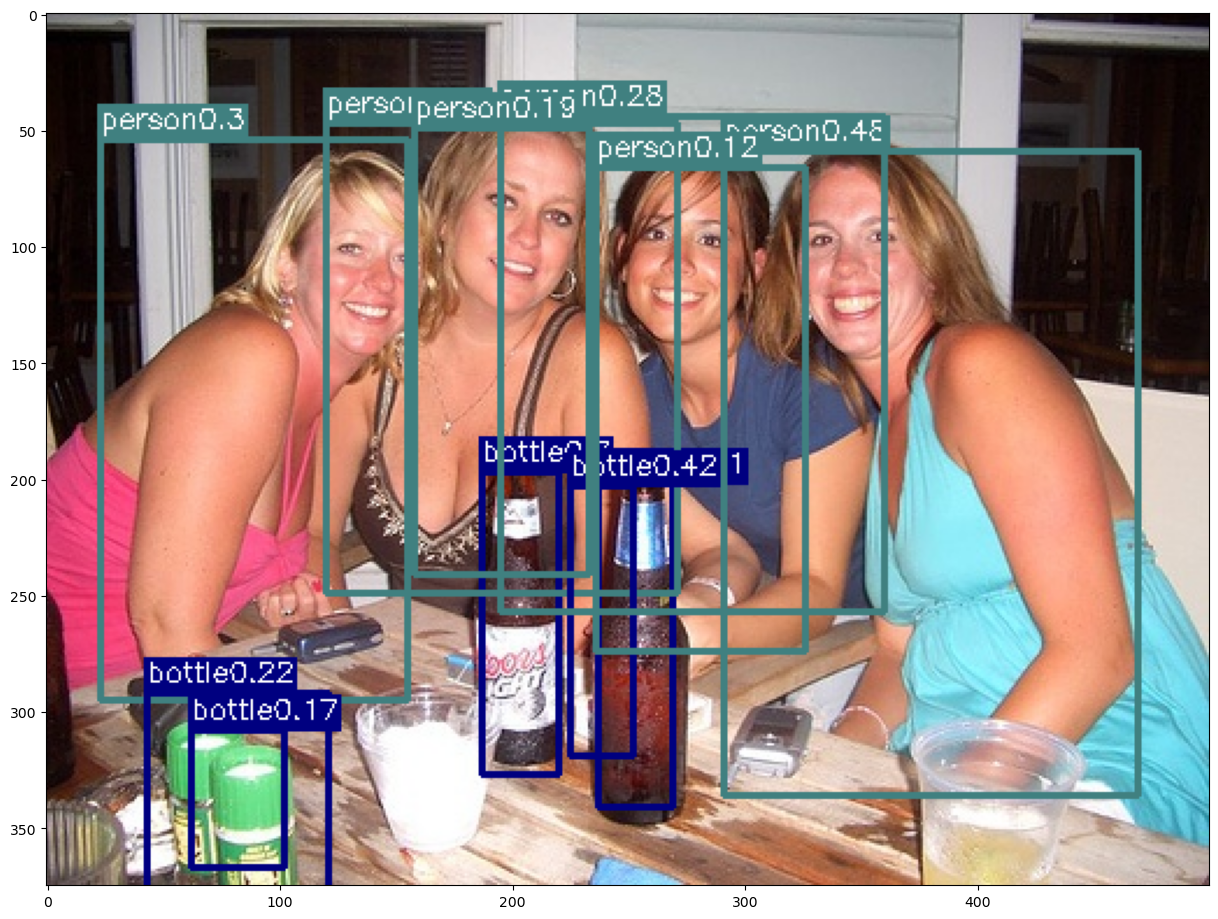

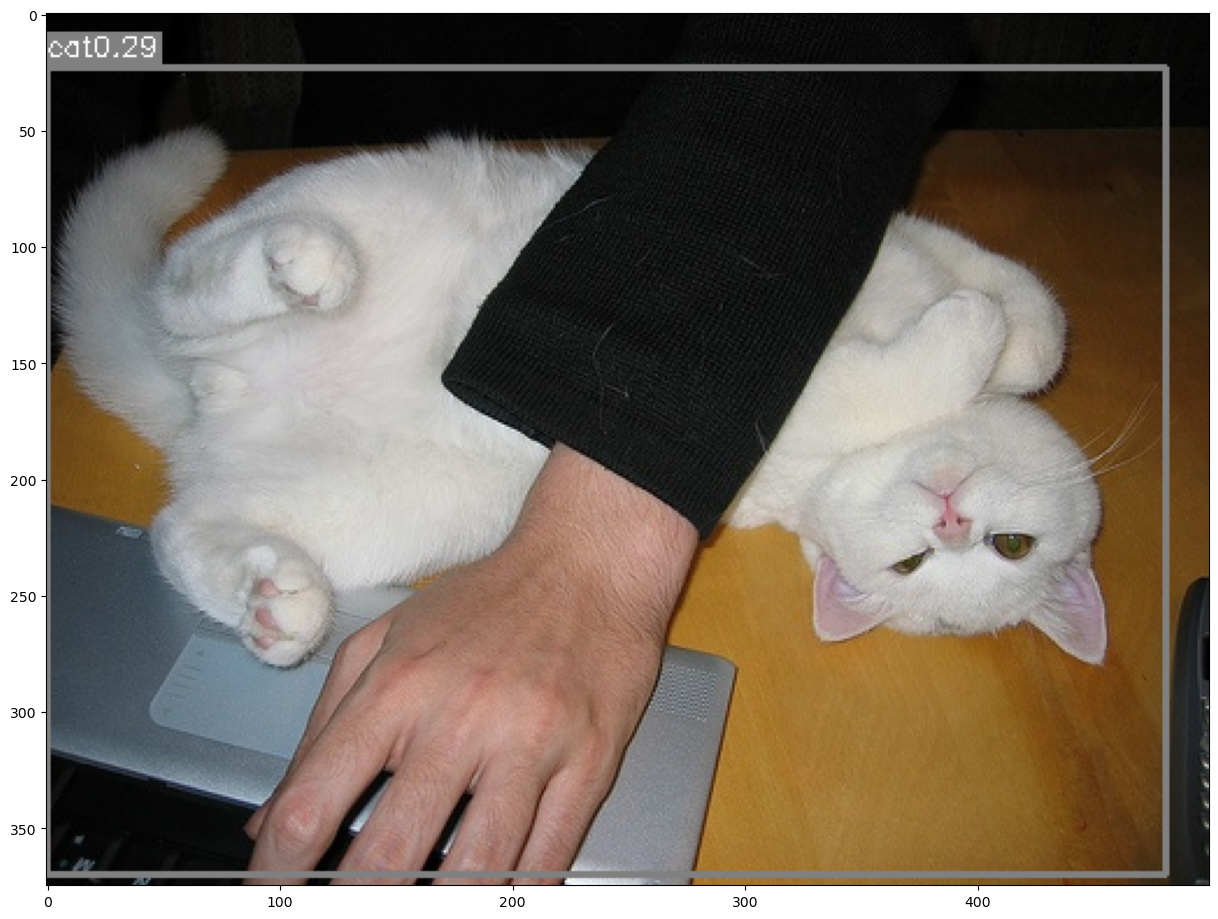

In [16]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)
plt.show()

## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [15]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:57<00:00, 42.11it/s]


---class aeroplane ap 0.5043015282278073---
---class bicycle ap 0.6773606137621415---
---class bird ap 0.44120655042767154---
---class boat ap 0.3099732563984594---
---class bottle ap 0.14375537777761727---
---class bus ap 0.6226174894737079---
---class car ap 0.6408518217644554---
---class cat ap 0.7202477122819776---
---class chair ap 0.2830660821498139---
---class cow ap 0.5343924785756844---
---class diningtable ap 0.39049601310690446---
---class dog ap 0.7003474780529089---
---class horse ap 0.709946997774902---
---class motorbike ap 0.5869946522882454---
---class person ap 0.500431298258442---
---class pottedplant ap 0.17273352365610106---
---class sheep ap 0.451075143224862---
---class sofa ap 0.4511487227192126---
---class train ap 0.636534752306345---
---class tvmonitor ap 0.47180636270716836---
---map 0.4974643927467214---


### Cell added to get intermediate mAP values for students

In [12]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


C:\Users\Carlos\AppData\Local\Temp\ipykernel_68196\3582792252.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded.load_state_dict(torch.load(load_network_path))
1

---class aeroplane ap 0.5043015282278073---
---class bicycle ap 0.6773606137621415---
---class bird ap 0.44120655042767154---
---class boat ap 0.3099732563984594---
---class bottle ap 0.14375537777761727---
---class bus ap 0.6226174894737079---
---class car ap 0.6408518217644554---
---class cat ap 0.7202477122819776---
---class chair ap 0.2830660821498139---
---class cow ap 0.5343924785756844---
---class diningtable ap 0.39049601310690446---
---class dog ap 0.7003474780529089---
---class horse ap 0.709946997774902---
---class motorbike ap 0.5869946522882454---
---class person ap 0.500431298258442---
---class pottedplant ap 0.17273352365610106---
---class sheep ap 0.451075143224862---
---class sofa ap 0.4511487227192126---
---class train ap 0.636534752306345---
---class tvmonitor ap 0.47180636270716836---
---map 0.4974643927467214---
Loading saved network from ./checkpoints/detector_epoch_10.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:06<00:00, 39.03it/s]


---class aeroplane ap 0.5110567491542779---
---class bicycle ap 0.674480392409495---
---class bird ap 0.4780949143035722---
---class boat ap 0.32924003045234157---
---class bottle ap 0.1794282706619576---
---class bus ap 0.6534453182960254---
---class car ap 0.6756108689264962---
---class cat ap 0.7452438391597491---
---class chair ap 0.31853263580898583---
---class cow ap 0.5412112448838335---
---class diningtable ap 0.4021632294061467---
---class dog ap 0.6661154121963877---
---class horse ap 0.6877876659752677---
---class motorbike ap 0.6025386560725838---
---class person ap 0.5372200630967134---
---class pottedplant ap 0.20253881333901438---
---class sheep ap 0.5220922571866156---
---class sofa ap 0.45537918241163866---
---class train ap 0.6397049940836173---
---class tvmonitor ap 0.510919574874078---
---map 0.5166402056349398---
Loading saved network from ./checkpoints/detector_epoch_20.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:57<00:00, 42.12it/s]


---class aeroplane ap 0.5006551915521552---
---class bicycle ap 0.6521257371183233---
---class bird ap 0.5038827315301657---
---class boat ap 0.31808675488603955---
---class bottle ap 0.19228929347757973---
---class bus ap 0.6397279278990682---
---class car ap 0.6703458933671793---
---class cat ap 0.7204356908763405---
---class chair ap 0.31472819355040776---
---class cow ap 0.5327150778903096---
---class diningtable ap 0.4099861993724629---
---class dog ap 0.6795501071438432---
---class horse ap 0.6901173009282385---
---class motorbike ap 0.5725876614730714---
---class person ap 0.5278891205282898---
---class pottedplant ap 0.20185695873046092---
---class sheep ap 0.5622749196434329---
---class sofa ap 0.466511382098481---
---class train ap 0.6638215654472981---
---class tvmonitor ap 0.5078679577865801---
---map 0.5163727832649865---
Loading saved network from ./checkpoints/detector_epoch_30.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:00<00:00, 41.09it/s]


---class aeroplane ap 0.5126408624461706---
---class bicycle ap 0.6499911891811943---
---class bird ap 0.47430859538089265---
---class boat ap 0.30421514218030643---
---class bottle ap 0.21771085357592287---
---class bus ap 0.6351766447915375---
---class car ap 0.6521439609898358---
---class cat ap 0.7354743703531407---
---class chair ap 0.2972013341432842---
---class cow ap 0.5426697589065007---
---class diningtable ap 0.391612006607638---
---class dog ap 0.7103116364205384---
---class horse ap 0.7093316806054522---
---class motorbike ap 0.5964583079009742---
---class person ap 0.5393025843265367---
---class pottedplant ap 0.20267669908772426---
---class sheep ap 0.5168750789040628---
---class sofa ap 0.4833555047635203---
---class train ap 0.6726179563715806---
---class tvmonitor ap 0.5242733964409693---
---map 0.5184173781688891---
Loading saved network from ./checkpoints/detector_epoch_40.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:54<00:00, 43.40it/s]


---class aeroplane ap 0.5403329088723057---
---class bicycle ap 0.6556543122399183---
---class bird ap 0.48245977564699144---
---class boat ap 0.320627798817953---
---class bottle ap 0.22093955822030714---
---class bus ap 0.6629476605249436---
---class car ap 0.6731571927762183---
---class cat ap 0.7523523345257749---
---class chair ap 0.30703935003731087---
---class cow ap 0.5721623901763406---
---class diningtable ap 0.41948266224621017---
---class dog ap 0.7113147473374744---
---class horse ap 0.7049122825553402---
---class motorbike ap 0.594526539702253---
---class person ap 0.549978898577127---
---class pottedplant ap 0.19079762070785428---
---class sheep ap 0.5179085645579579---
---class sofa ap 0.487863932501518---
---class train ap 0.6926581650418158---
---class tvmonitor ap 0.5210537105530005---
---map 0.5289085202809308---
Loading saved network from ./checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:52<00:00, 43.98it/s]


---class aeroplane ap 0.5199347133762378---
---class bicycle ap 0.6450768543333061---
---class bird ap 0.4755365579429922---
---class boat ap 0.30737793462051---
---class bottle ap 0.2251165204198575---
---class bus ap 0.6444623868161096---
---class car ap 0.6771611815121986---
---class cat ap 0.7506164934794777---
---class chair ap 0.3184645416355998---
---class cow ap 0.571003279436451---
---class diningtable ap 0.42045781590074527---
---class dog ap 0.7120105384546528---
---class horse ap 0.7259033330174778---
---class motorbike ap 0.5900654800044449---
---class person ap 0.5560240021108713---
---class pottedplant ap 0.20281269780599842---
---class sheep ap 0.5139754075810762---
---class sofa ap 0.4963874931959104---
---class train ap 0.686051554091478---
---class tvmonitor ap 0.520484378909302---
---map 0.5279461582322349---


In [16]:
output_submission_csv('my_solution.csv', test_aps)